<h1 align=center><font size = 5>Checking neighborhood similarities of 3 sister cities</font></h1>

## Introduction

In this final contest, I analyzed and presented the places to visit and eat from the city I live in, Chisinau, Moldova and compared them with his 2 sister cities from neighbor countries, Iasi - Romania & Odessa - Ukraine. Also grouped them according to neighborhood in order to detect the one with the highest feedback score on Foursquare.

## Table of Contents

<div class="alert alert-primary" role="alert" style="margin-top: 10px">
    
<font size = 3>

1. <a href="#item1" class="alert-link">Import and Explore Dataset</a>

2. <a href="#item2" class="alert-link">Explore Neighborhoods</a>

3. <a href="#item3" class="alert-link">Analyze venues type</a>

4. <a href="#item4" class="alert-link">Cluster Neighborhoods</a>

5. <a href="#item5" class="alert-link">Examine Clusters</a>    
</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda update -n base -c defaults conda
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Import and Explore Dataset

I collected all neighborhood/sectors data from various data sources, but mostly on Wikipedia. You can check the data at:
https://github.com/boombasteek/ADSC_COURSERA/blob/master/neighborhood_sector_3cities.xlsx

In [2]:
import os
print(os.listdir("../applied data science capstone"))

['.ipynb_checkpoints', '3_cities_analysis.ipynb', 'Canada_postal_codes.xlsx', 'car_traffic_load.csv', 'chisinau_cartiere.xlsx', 'Denis_Final_Report.docx', 'district_only_3cities.xlsx', 'DP0701EN-3-3-2-Neighborhoods-New-York-py-v1.0.ipynb', 'iasi_cartiere.xlsx', 'iasi_wards.csv', 'instructions.txt', 'LPG_data.csv', 'MinhNgo_Final_Report.docx', 'myLPGeu.bmp', 'myLPGeu.zip', 'neighborhood_3cities.xlsx', 'neighborhood_sector_3cities.xlsx', 'odessa_wards.csv']


#### Load and explore the data

Next, let's load the data.

In [3]:
df = pd.read_excel("../applied data science capstone/neighborhood_3cities.xlsx")

Let's take a quick look at the data.

In [4]:
df

,Neighborhood,City,Country
0,Rîșcani,Chisinau,Moldova
1,Ciocana,Chisinau,Moldova
2,Botanica,Chisinau,Moldova
3,Buiucani,Chisinau,Moldova
4,Centru,Chisinau,Moldova
5,Pasajul Alexandru cel Bun,Iasi,Romania
6,Bucium,Iasi,Romania
7,Bucșinescu,Iasi,Romania
8,Canta,Iasi,Romania
9,Cantemir,Iasi,Romania


#### Use geopy library to get the latitude and longitude values of Chisinau

I use Nominatim Geocoding service, which is built on top of OpenStreetMap data. Let us Geocode a single address, for a particular sector data in Chisinau.

In [5]:
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Mălina Mică, Chisinau, Moldova")

In [6]:
print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 47.0108275, Longitude = 28.8500097


We can join address columns in pandas like this to create an address column for the geocoding.

In [7]:
df['ADDRESS'] = df[['Neighborhood', 'City', 'Country']].apply(lambda x: ','.join(x), axis=1)
df['ADDRESS']

0                       Rîșcani,Chisinau,Moldova
1                       Ciocana,Chisinau,Moldova
2                      Botanica,Chisinau,Moldova
3                      Buiucani,Chisinau,Moldova
4                        Centru,Chisinau,Moldova
5         Pasajul Alexandru cel Bun,Iasi,Romania
6                            Bucium,Iasi,Romania
7                        Bucșinescu,Iasi,Romania
8                             Canta,Iasi,Romania
9                          Cantemir,Iasi,Romania
10                           Centru,Iasi,Romania
11                            Copou,Iasi,Romania
12                           C.U.G.,Iasi,Romania
13                            Dacia,Iasi,Romania
14                         Frumoasa,Iasi,Romania
15                           Galata,Iasi,Romania
16                             Gară,Iasi,Romania
17                Mircea cel Bătrân,Iasi,Romania
18                     Moara de Foc,Iasi,Romania
19                    Moara de Vânt,Iasi,Romania
20                  

Separate dataframe for each city.

In [8]:
df_ch = df[df['City'] == 'Chisinau'].reset_index(drop=True)
df_ode = df[df['City'] == 'Одесса'].reset_index(drop=True)
df_iasi = df[df['City'] == 'Iasi'].reset_index(drop=True)
#df_ch = df_ch.groupby(["Neighborhood"], sort=False, as_index=False).first()
#df_ode = df_ode.groupby(["Neighborhood"], sort=False, as_index=False).first()
df_ch

,Neighborhood,City,Country,ADDRESS
0,Rîșcani,Chisinau,Moldova,"Rîșcani,Chisinau,Moldova"
1,Ciocana,Chisinau,Moldova,"Ciocana,Chisinau,Moldova"
2,Botanica,Chisinau,Moldova,"Botanica,Chisinau,Moldova"
3,Buiucani,Chisinau,Moldova,"Buiucani,Chisinau,Moldova"
4,Centru,Chisinau,Moldova,"Centru,Chisinau,Moldova"


Once we create the address column, we can start geocoding as below code snippet. First, we get geodata for Chisinau.

In [9]:
from geopy.extra.rate_limiter import RateLimiter

# 1 - convenient function to delay between geocoding calls, in case of errors it waits for a period
geocode = RateLimiter(locator.geocode, min_delay_seconds=1, max_retries=2, error_wait_seconds=1.0)
# 2 - create location column
df_ch['location'] = df_ch['ADDRESS'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
df_ch['point'] = df_ch['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
df_ch[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_ch['point'].tolist(), index=df_ch.index)

In [117]:
df_ch.head()

,Neighborhood,City,Country,ADDRESS,location,point,latitude,longitude,altitude
0,Rîșcani,Chisinau,Moldova,"Rîșcani,Chisinau,Moldova","(Rîșcani, Chișinău, Sectorul Rîșcani, Municipi...","(47.0470594, 28.8623906, 0.0)",47.047059,28.862391,0.0
1,Ciocana,Chisinau,Moldova,"Ciocana,Chisinau,Moldova","(Sectorul Ciocana, Municipiul Chișinău, Moldov...","(47.0362473, 28.8893518, 0.0)",47.036247,28.889352,0.0
2,Botanica,Chisinau,Moldova,"Botanica,Chisinau,Moldova","(Sectorul Botanica, Municipiul Chișinău, Moldo...","(46.9861816, 28.8573392, 0.0)",46.986182,28.857339,0.0
3,Buiucani,Chisinau,Moldova,"Buiucani,Chisinau,Moldova","(Sectorul Buiucani, Municipiul Chișinău, Moldo...","(47.0379511, 28.8127488, 0.0)",47.037951,28.812749,0.0
4,Centru,Chisinau,Moldova,"Centru,Chisinau,Moldova","(Sectorul Centru, Municipiul Chișinău, Moldova...","(47.0178414, 28.8337873, 0.0)",47.017841,28.833787,0.0


Now, we get data for other 2 sister cities, Odessa & Iasi. We eliminate N/A values from Odessa geodata & detect some sectors in Iasi city that could be duplicated, in order to avoid confussions.

In [10]:
locator_iasi = Nominatim(user_agent="myGeocoder2",)
list_iasi = []
list_iasi = locator_iasi.geocode("Alexandru cel Bun, Iasi", exactly_one=False)
list_iasi.append(locator_iasi.geocode("Tudor Vladimirescu, Iasi", exactly_one=False))
print(list_iasi)

[Location(Alexandru cel Bun, Iași, 707591, România, (47.4579873, 27.2930093, 0.0)), Location(Alexandru cel Bun, Iași, 700630, România, (47.163837, 27.5630556, 0.0)), Location(Iasi, Strada Cișmeaua Păcurari, Iași, Alexandru cel Bun, Iași, 700135, România, (47.1704644, 27.5643673, 0.0)), Location(Alexandru cel Bun, Pasajul Alexandru cel Bun, Iași, Gară, Iași, 700585, România, (47.16406225, 27.561800431096124, 0.0)), Location(Alexandru cel Bun, Piața Voievozilor, Iași, Alexandru cel Bun, Iași, 700587, România, (47.1619552, 27.5630047, 0.0)), [Location(Tudor Vladimirescu, Mogoșești-Siret, Iași, 707337, România, (47.1334588, 26.784756, 0.0)), Location(Tudor Vladimirescu, Bulevardul Chimiei, Podu Roș, Zona Industrială, Iași, 700393, România, (47.15600285, 27.601660741858534, 0.0)), Location(Tudor Vladimirescu, Bulevardul Tudor Vladimirescu, Iași, Baza 3, Iași, 700311, România, (47.1565602, 27.603451, 0.0)), Location(Tudor Vladimirescu, Bulevardul Tudor Vladimirescu, Iași, Baza 3, Iași, 70031

In [116]:
df_ode['location'] = df_ode['ADDRESS'].apply(geocode)
df_ode['point'] = df_ode['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df_ode[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_ode['point'].tolist(), index=df_ode.index)
df_ode = df_ode.dropna()

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Приморский,Одесса,Украина',), **{}).
Traceback (most recent call last):
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1026, in _send_output
    self.send(msg)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\

RateLimiter caught an error, retrying (0/2 tries). Called with (*('Суворовский,Одесса,Украина',), **{}).
Traceback (most recent call last):
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\urllib\request.py", line 1317, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1244, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1290, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1239, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http\client.py", line 1026, in _send_output
    self.send(msg)
  File "C:\Users\edenibr\AppData\Local\Continuum\anaconda3\lib\http

In [12]:
geocode_iasi = RateLimiter(locator_iasi.geocode, min_delay_seconds=1, 
                           max_retries=2, error_wait_seconds=1.0)
df_iasi['location'] = df_iasi['ADDRESS'].apply(geocode_iasi)
df_iasi['point'] = df_iasi['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df_iasi[['latitude', 'longitude', 'altitude']] = pd.DataFrame(df_iasi['point'].tolist(), index=df_iasi.index)
df_iasi = df_iasi.dropna()

<a id='item2'></a>

## 2. Explore Neighborhoods

I will use Folium to map out the points we created but feel free to use any other Geovisualization tool of your choice. First, we display the locations as a circle map with Folium.

In [13]:
map1 = folium.Map(
    location=[47.0108275,28.8500097],
    tiles='cartodbpositron',
    zoom_start=10,
)
df_ch.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map1), axis=1)
map1

In [14]:
map2 = folium.Map(
    location=[46.431789,30.760832],
    tiles='cartodbpositron',
    zoom_start=10,
)
df_ode.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map2), axis=1)
map2

In [15]:
map3 = folium.Map(
    location=[47.166013,27.580047],
    tiles='cartodbpositron',
    zoom_start=12,
)
df_iasi.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map3), axis=1)
map3

#### Merge all filtered dataframes into a single final one 

Take a look at the empty dataframe to confirm that the columns are as intended.

In [16]:
# define empty dataframe and define the columns
columns = ['Neighborhood','City','latitude','longitude']
df_final = pd.DataFrame(columns=columns)
df_final

,Neighborhood,City,latitude,longitude


In [17]:
# concatenate 3 dataframes and leave only relevant columns
df_final = df_final.append([df_ch[columns],df_ode[columns],df_iasi[columns]]).reset_index()

In [18]:
# drop the column with old index values and take a look at final dataframe
df_final = df_final.drop('index',axis=1)
df_final.head()

,Neighborhood,City,latitude,longitude
0,Rîșcani,Chisinau,47.047059,28.862391
1,Ciocana,Chisinau,47.036247,28.889352
2,Botanica,Chisinau,46.986182,28.857339
3,Buiucani,Chisinau,47.037951,28.812749
4,Centru,Chisinau,47.017841,28.833787


Take a look at neighborhoods from the 3 cities & statistics for all these cities.

In [19]:
print('The 3 cities have totally {} neighborhoods.'.format(
        len(df_final['Neighborhood'].unique()),
        df_final.shape[0]
    )
)

The 3 cities have totally 32 neighborhoods.


In [20]:
map4 = folium.Map(
    location=[46.642997, 29.408672],
    tiles='cartodbpositron',
    zoom_start=7,
)
df_final.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]]).add_to(map4), axis=1)
map4

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods.

<a id='item3'></a>

## 3. Analyze venues type

#### Let's create a function to get the venues for all the neighborhoods

In [21]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Define Foursquare Credentials and Version

In [23]:
CLIENT_ID = 'VLMQFG0JV3TN1VQ3OKEIUSO4V021QB5JRNTSSONVKU3QICQO' # your Foursquare ID
CLIENT_SECRET = 'K1PXCJBLD2LYPVTZGQO3YF1GWOPNKT5NUMNI2M2ZVT3SK5N1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: VLMQFG0JV3TN1VQ3OKEIUSO4V021QB5JRNTSSONVKU3QICQO
CLIENT_SECRET:K1PXCJBLD2LYPVTZGQO3YF1GWOPNKT5NUMNI2M2ZVT3SK5N1


#### Now write the code to run the above function on each neighborhood and create a new dataframe called *ch_venues* in case of Chisinau ones, then the same action done for the other 2 cities.

In [24]:
ch_venues = getNearbyVenues(names=df_ch['Neighborhood'],
                                   latitudes=df_ch['latitude'],
                                   longitudes=df_ch['longitude'])

Rîșcani
Ciocana
Botanica
Buiucani
Centru


In [25]:
ode_venues = getNearbyVenues(names=df_ode['Neighborhood'],
                                   latitudes=df_ode['latitude'],
                                   longitudes=df_ode['longitude'])
iasi_venues = getNearbyVenues(names=df_iasi['Neighborhood'],
                                   latitudes=df_iasi['latitude'],
                                   longitudes=df_iasi['longitude'])

Приморский
Малиновский
Суворовский
Киевский
Pasajul Alexandru cel Bun
Bucium
Bucșinescu
Canta
Cantemir
Centru
Copou
C.U.G.
Dacia
Frumoasa
Galata
Gară
Mircea cel Bătrân
Moara de Foc
Moara de Vânt
Nicolina
Păcurari
Podu Roș
Sărărie
Socola
Târgu Cucu
Tătărași
Bulevardul Tudor Vladimirescu
Țicău


#### Let's check the size of the resulting dataframes

In [26]:
print(ch_venues.shape)
ch_venues.head()

(98, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rîșcani,47.047059,28.862391,Granier,47.045826,28.862243,Bakery
1,Rîșcani,47.047059,28.862391,Tucano Coffee Kenya,47.044352,28.860449,Coffee Shop
2,Rîșcani,47.047059,28.862391,Crosta Kitchen & Bakery,47.050582,28.864169,Bakery
3,Rîșcani,47.047059,28.862391,MaXfitness,47.050797,28.862747,Gym
4,Rîșcani,47.047059,28.862391,La Plăcinte,47.049378,28.862717,Romanian Restaurant


In [27]:
print(ode_venues.shape)
ode_venues.head()

(74, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Приморский,46.458423,30.748185,Музей Интересной Науки,46.459916,30.749670,Science Museum
1,Приморский,46.458423,30.748185,Casa Romani,46.457905,30.750368,Italian Restaurant
2,Приморский,46.458423,30.748185,Fortis Bike,46.461128,30.747939,Bike Shop
3,Приморский,46.458423,30.748185,"Хоспер Кафе ""Как Есть""",46.461015,30.748981,Café
4,Приморский,46.458423,30.748185,KAMI,46.457246,30.752022,Sushi Restaurant


We can see that the most of venues on Foursquare are in Iasi. Next, let's see the neighborhoods with most venues for each city.

In [28]:
print(iasi_venues.shape)
iasi_venues.head()

(240, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Pasajul Alexandru cel Bun,47.159593,27.575295,Kaufland,47.161430,27.575791,Department Store
1,Pasajul Alexandru cel Bun,47.159593,27.575295,Buena Vista,47.163030,27.576051,South American Restaurant
2,Pasajul Alexandru cel Bun,47.159593,27.575295,Piața Agroalimentară Alexandru cel Bun,47.160631,27.571945,Farmers Market
3,Bucium,47.117054,27.634113,Restaurant La Plopii fără Soț,47.119293,27.630433,Restaurant
4,Bucium,47.117054,27.634113,Pensiunea Novis,47.116098,27.632514,Bed & Breakfast


### Now, let's see how many venue types are in each city

In [118]:
print('There are {} uniques venue categories in Chisinau.'.format(len(ch_venues['Venue Category'].unique())))

There are 47 uniques venue categories in Chisinau.


In [30]:
print('There are {} uniques categories.'.format(len(ode_venues['Venue Category'].unique())))

There are 49 uniques categories.


In [31]:
print('There are {} uniques categories.'.format(len(iasi_venues['Venue Category'].unique())))

There are 80 uniques categories.


The top 20 venues in the 3 cities differ. Hotel venue anyway is in top 3 for all of them. Let's check them out.

Text(0.5, 0.98, 'Chisinau venues')

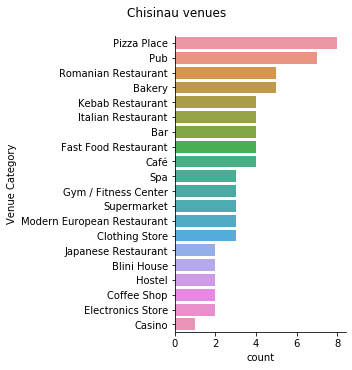

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.catplot(y='Venue Category', data=ch_venues, kind='count', order=ch_venues['Venue Category'].value_counts().iloc[:20].index)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Chisinau venues')

Text(0.5, 0.98, 'Odessa venues')

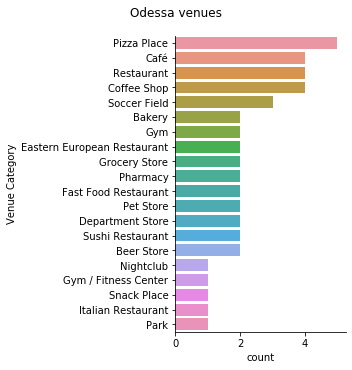

In [68]:
g = sns.catplot(y='Venue Category', data=ode_venues, kind='count', order=ode_venues['Venue Category'].value_counts().iloc[:20].index)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Odessa venues')

Text(0.5, 0.98, 'Iasi venues')

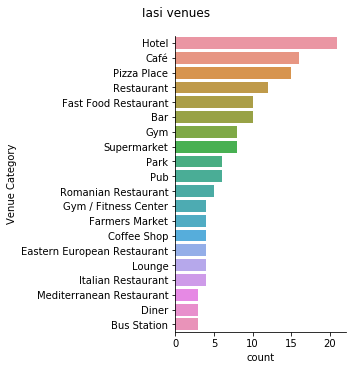

In [69]:
g = sns.catplot(y='Venue Category', data=iasi_venues, kind='count', order=iasi_venues['Venue Category'].value_counts().iloc[:20].index)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Iasi venues')

As expected, the central areas of each city have the most venues.

In [35]:
ch_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Botanica,26,26,26,26,26,26
Buiucani,9,9,9,9,9,9
Centru,42,42,42,42,42,42
Ciocana,5,5,5,5,5,5
Rîșcani,16,16,16,16,16,16


In [36]:
ode_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Киевский,29,29,29,29,29,29
Малиновский,8,8,8,8,8,8
Приморский,33,33,33,33,33,33
Суворовский,4,4,4,4,4,4


In [37]:
iasi_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bucium,4,4,4,4,4,4
Bucșinescu,20,20,20,20,20,20
Bulevardul Tudor Vladimirescu,28,28,28,28,28,28
C.U.G.,2,2,2,2,2,2
Canta,8,8,8,8,8,8
Cantemir,5,5,5,5,5,5
Centru,53,53,53,53,53,53
Copou,11,11,11,11,11,11
Dacia,5,5,5,5,5,5


#### Let's explore the central neighborhood in Chisinau dataframe.

Get the neighborhood's name.

In [38]:
df_ch.loc[4, 'Neighborhood']

'Centru'

In [39]:
neighborhood_latitude = df_ch.loc[4, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_ch.loc[4, 'longitude'] # neighborhood longitude value

neighborhood_name = df_ch.loc[4, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Centru are 47.0178414, 28.8337873.


Let's check the scoring of neighborhood venues.

In [40]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VLMQFG0JV3TN1VQ3OKEIUSO4V021QB5JRNTSSONVKU3QICQO&client_secret=K1PXCJBLD2LYPVTZGQO3YF1GWOPNKT5NUMNI2M2ZVT3SK5N1&v=20180605&ll=47.0178414,28.8337873&radius=2000&limit=100'

In [41]:
ch_centru = requests.get(url).json()
ch_centru

{'meta': {'code': 200, 'requestId': '5e26d68d006dce001b2949eb'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Chişinău',
  'headerFullLocation': 'Chişinău',
  'headerLocationGranularity': 'city',
  'totalResults': 150,
  'suggestedBounds': {'ne': {'lat': 47.03584141800002, 'lng': 28.860139873978},
   'sw': {'lat': 46.999841381999985, 'lng': 28.807434726022002}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '545dcdef498e80afb339a30a',
       'name': 'Eclair - Tea, Decor & Lifestyle Shop',
       'location': {'address': 'Str. Mihai Eminescu, 30',
        'crossStreet': 'Întrare de pe str. Alexei Șciusev',
        'lat': 47.017683,
        'lng': 28.831459,
        'labeledLatLng

The same actions to be done for Odessa & Iasi.

In [42]:
df_ode.loc[0, 'Neighborhood']

'Приморский'

In [43]:
neighborhood_latitude = df_ode.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_ode.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = df_ode.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Приморский are 46.458423100000005, 30.74818510648148.


In [44]:
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VLMQFG0JV3TN1VQ3OKEIUSO4V021QB5JRNTSSONVKU3QICQO&client_secret=K1PXCJBLD2LYPVTZGQO3YF1GWOPNKT5NUMNI2M2ZVT3SK5N1&v=20180605&ll=46.458423100000005,30.74818510648148&radius=2000&limit=100'

In [45]:
odessa_prim = requests.get(url).json()
odessa_prim

{'meta': {'code': 200, 'requestId': '5e26d6eb47e0d60025634cb9'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Odesa',
  'headerFullLocation': 'Odesa',
  'headerLocationGranularity': 'city',
  'totalResults': 169,
  'suggestedBounds': {'ne': {'lat': 46.47642311800002,
    'lng': 30.77426568648526},
   'sw': {'lat': 46.44042308199999, 'lng': 30.722104526477697}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '534cef74498e81f5e91236b3',
       'name': 'Музей Интересной Науки',
       'location': {'address': 'просп.Шевченко, 4е',
        'lat': 46.4599159249434,
        'lng': 30.74967036851131,
        'labeledLatLngs': [{'label': 'display',
          'lat': 46.4599159249434,
    

In [46]:
df_iasi.loc[5, 'Neighborhood']

'Centru'

In [47]:
neighborhood_latitude = df_iasi.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df_iasi.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = df_iasi.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Pasajul Alexandru cel Bun are 47.1595928, 27.575295.


In [48]:
 # create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=VLMQFG0JV3TN1VQ3OKEIUSO4V021QB5JRNTSSONVKU3QICQO&client_secret=K1PXCJBLD2LYPVTZGQO3YF1GWOPNKT5NUMNI2M2ZVT3SK5N1&v=20180605&ll=47.1595928,27.575295&radius=2000&limit=100'

In [49]:
iasi_centru = requests.get(url).json()
iasi_centru

{'meta': {'code': 200, 'requestId': '5e26d6dc98205d001ba272e3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Iaşi',
  'headerFullLocation': 'Iaşi',
  'headerLocationGranularity': 'city',
  'totalResults': 125,
  'suggestedBounds': {'ne': {'lat': 47.177592818000015,
    'lng': 27.60171780011259},
   'sw': {'lat': 47.14159278199998, 'lng': 27.548872199887413}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51bcda28498e1f99125c1a36',
       'name': 'Pietonal Ștefan cel Mare și Sfânt',
       'location': {'address': 'Bd. Ștefan cel Mare și Sfânt',
        'lat': 47.16046017564672,
        'lng': 27.58438456176009,
        'labeledLatLngs': [{'label': 'display',
          'lat': 4

I use the function **get_category_type** from the Foursquare lab to get venue details.

In [50]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [51]:
from pandas.io.json import json_normalize
venues = ch_centru['response']['groups'][0]['items']
nearby_venues_ch = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_ch =nearby_venues_ch.loc[:, filtered_columns]

# filter the category for each row
nearby_venues_ch['venue.categories'] = nearby_venues_ch.apply(get_category_type, axis=1)

#column formatting
nearby_venues_ch.columns = [col.split(".")[-1] for col in nearby_venues_ch.columns]
nearby_venues_ch

,name,id,categories,lat,lng
0,"Eclair - Tea, Decor & Lifestyle Shop",545dcdef498e80afb339a30a,Gift Shop,47.017683,28.831459
1,El Paso,4ca1eb71542b224b174912a0,Mexican Restaurant,47.014310,28.831710
2,Black Rabbit Gastro-Burrow,5afe09f8fe0e2a00249c6dcb,Café,47.021922,28.832701
3,Tucano Coffee Costa Rica,4e01cd3562e12fb0893b6271,Coffee Shop,47.020587,28.829305
4,Zentrum ApartHotel,5821b5d2da405933caceafa9,Hotel,47.020096,28.832609
5,Librarius,4f673046e4b045fbd62d1fd8,Bookstore,47.020403,28.829032
6,Pepe Pizza,53b6e4a6498eeed934ad66f6,Pizza Place,47.018157,28.836300
7,Radisson Blu Leogrand Hotel,54f87523498e22410ff0f9a1,Hotel,47.024315,28.836706
8,Smokehouse,5581bad5498e87c0da91c708,BBQ Joint,47.021236,28.838363
9,New York Restaurant & Bar,5631e6ba498ea2b71392aada,American Restaurant,47.024446,28.836601


And how many venues were returned by Foursquare?

In [52]:
print('{} venues were returned by Foursquare in Chisinau Centru.'.format(nearby_venues_ch.shape[0]))

100 venues were returned by Foursquare in Chisinau Centru.


Repeat the same actions for Odessa & Iasi.

In [53]:
venues = odessa_prim['response']['groups'][0]['items']
nearby_venues_ode = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_ode = nearby_venues_ode.loc[:, filtered_columns]

nearby_venues_ode['venue.categories'] = nearby_venues_ode.apply(get_category_type, axis=1)

nearby_venues_ode.columns = [col.split(".")[-1] for col in nearby_venues_ode.columns]
nearby_venues_ode

,name,id,categories,lat,lng
0,Музей Интересной Науки,534cef74498e81f5e91236b3,Science Museum,46.459916,30.749670
1,Fortis Bike,531d977e498e3106ae093b53,Bike Shop,46.461128,30.747939
2,Casa Romani,522dbe6911d27ece36554c4a,Italian Restaurant,46.457905,30.750368
3,"Хоспер Кафе ""Как Есть""",53ecae55498e33680fda27f3,Café,46.461015,30.748981
4,Rozetka,5bf04ee789b06a002c36a239,Electronics Store,46.460276,30.740799
5,KAMI,4e8ddfc5b803ca3dfcf5a336,Sushi Restaurant,46.457246,30.752022
6,Make My Cake Cafe,5a87e75592e7a97e7ef306ae,Dessert Shop,46.463345,30.754717
7,Wine Story - Винфорт,4d232dae8bc86a31da7d2da8,Wine Shop,46.463149,30.741597
8,Зелень,53451174498ecc1ac3410fa4,Vegetarian / Vegan Restaurant,46.465264,30.746205
9,Jysk / Юск,4f896e77e4b01f95a2ddaa03,Furniture / Home Store,46.462308,30.741140


In [54]:
venues = iasi_centru['response']['groups'][0]['items']
nearby_venues_iasi = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues_iasi = nearby_venues_iasi.loc[:, filtered_columns]

nearby_venues_iasi['venue.categories'] = nearby_venues_iasi.apply(get_category_type, axis=1)

nearby_venues_iasi.columns = [col.split(".")[-1] for col in nearby_venues_iasi.columns]
nearby_venues_iasi

,name,id,categories,lat,lng
0,Pietonal Ștefan cel Mare și Sfânt,51bcda28498e1f99125c1a36,Pedestrian Plaza,47.160460,27.584385
1,Jassyro,53f5af7d498e9554d500bf56,Coffee Shop,47.164405,27.580999
2,"Teatrul Național ""Vasile Alecsandri""",4ead89a3d3e32ee0de625442,Theater,47.163045,27.584653
3,CUIB,52a5af33498eff5d74e4fbf3,Vegetarian / Vegan Restaurant,47.167107,27.577135
4,Palatul Culturii,4d205b1b16cfb60cd0805861,Palace,47.157243,27.586938
5,Chef Galerie,53d16482498e713d026a978c,Mediterranean Restaurant,47.155871,27.586584
6,Bistro Piața Unirii,56571c2e498e51f6dc4bb9a2,Sushi Restaurant,47.166224,27.580831
7,Grădina Publică Palas,4fcb5445e4b0e33fd4b8b21f,Garden,47.156178,27.587636
8,Buena Vista,4bb0e2d5f964a520ba663ce3,South American Restaurant,47.163030,27.576051
9,Piața Unirii,4d728bae27ddb60c119ecf1b,Plaza,47.165562,27.580881


###### Now let's see the venue rating

In [55]:
#get first the ID for Chisinau venues
venue_id_list_ch = nearby_venues_ch['id'].tolist()
venue_id_list_ch[:5]

['545dcdef498e80afb339a30a',
 '4ca1eb71542b224b174912a0',
 '5afe09f8fe0e2a00249c6dcb',
 '4e01cd3562e12fb0893b6271',
 '5821b5d2da405933caceafa9']

In [56]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list_ch = []
json_list = []

for i in venue_id_list_ch:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list_ch.append(likes)
print(like_list_ch[:5])

[24, 197, 35, 435, 12]


{'meta': {'code': 200, 'requestId': '5e26d788df2774001c149aba'},
 'response': {'likes': {'count': 15,
   'summary': '15 Likes',
   'items': [{'id': '144946717',
     'firstName': 'Victor',
     'lastName': 'S',
     'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
      'suffix': '/144946717-XCG2ZXKUJABZ3UB0.jpg'}},
    {'id': '30169920',
     'firstName': 'Rassel',
     'lastName': 'C',
     'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
      'suffix': '/30169920_6KuscPY0_LsiL84zIkPDmHLEGHY24rpVWMVd9QDsUr15ibJ8UmLlGAKqtN-yudjqcjyT5M5LD.jpg'}},
    {'id': '47204440',
     'firstName': 'Faruk',
     'lastName': 'M',
     'photo': {'prefix': 'https://fastly.4sqi.net/img/user/',
      'suffix': '/HFSLVSK2WOEOCLXS.jpg'}}]}}}

In [86]:
like_list_ch.sort(reverse=True)
print(like_list_ch)

[435, 429, 343, 311, 258, 227, 207, 197, 185, 183, 181, 173, 164, 136, 135, 132, 121, 121, 115, 113, 113, 109, 107, 102, 88, 84, 78, 73, 72, 69, 63, 62, 56, 53, 52, 42, 38, 36, 36, 35, 34, 33, 33, 33, 31, 29, 29, 29, 27, 26, 25, 25, 24, 24, 23, 22, 18, 17, 17, 16, 16, 15, 15, 15, 14, 14, 14, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 7, 7, 7, 6, 6, 5, 5, 5, 3]


In [57]:
#get first the ID for Chisinau venues
venue_id_list_ode = nearby_venues_ode['id'].tolist()

In [58]:
#set up to pull the likes from the API based on venue ID

url_list.clear()
like_list_ode = []
json_list.clear()

for i in venue_id_list_ode:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)

for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list_ode.append(likes)
print(like_list_ode[:5])

[119, 14, 78, 69, 14]


In [87]:
like_list_ode.sort(reverse=True)
print(like_list_ode)

[1372, 1355, 1127, 1053, 761, 547, 469, 461, 456, 447, 395, 374, 333, 264, 260, 240, 240, 196, 188, 180, 178, 147, 146, 137, 133, 132, 120, 119, 116, 112, 112, 109, 102, 93, 91, 85, 81, 78, 69, 68, 64, 63, 54, 49, 48, 44, 42, 41, 40, 39, 30, 28, 28, 27, 27, 26, 26, 25, 24, 24, 23, 23, 21, 20, 19, 18, 18, 16, 16, 16, 15, 15, 15, 14, 14, 14, 13, 13, 12, 12, 12, 12, 12, 11, 11, 10, 9, 9, 9, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 5]


In [59]:
#get first the ID for Chisinau venues
venue_id_list_iasi = nearby_venues_iasi['id'].tolist()

In [91]:
#set up to pull the likes from the API based on venue ID

url_list.clear()
like_list_iasi = []
json_list.clear()

for i in venue_id_list_iasi:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)

for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list_iasi.append(likes)
print(like_list_iasi[:5])

[59, 25, 43, 52, 74]


In [92]:
like_list_iasi.sort(reverse=True)
print(like_list_iasi)

[493, 143, 141, 137, 136, 127, 126, 100, 98, 96, 82, 80, 77, 74, 73, 66, 63, 60, 60, 59, 59, 56, 55, 55, 53, 52, 51, 50, 47, 45, 44, 43, 42, 40, 39, 39, 37, 34, 33, 33, 32, 32, 31, 30, 30, 30, 28, 28, 26, 26, 25, 25, 22, 21, 21, 20, 20, 19, 19, 19, 17, 17, 17, 16, 16, 16, 16, 16, 16, 15, 15, 15, 13, 13, 13, 12, 12, 12, 12, 12, 12, 11, 11, 10, 10, 10, 10, 10, 8, 8, 8, 8, 8, 8, 8, 6, 6, 5, 5, 2]


From a simple comparison of likes count of the venues in 3 cities, we can clearly see that in Odessa are most active users; while in Chisinau and Iasi, they are aproximately the same user patterns.
Next, we will see whether the venues that are being present in a city are also in the other one.

In [95]:
# one hot encoding
ch_onehot = pd.get_dummies(ode_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ch_onehot['Neighborhood'] = ch_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ch_onehot.columns[-1]] + list(ch_onehot.columns[:-1])
ch_onehot = ch_onehot[fixed_columns]

ch_onehot.head()

,Neighborhood,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Bakery,Beach,Bed & Breakfast,Beer Store,Bike Shop,Bistro,Bus Stop,Café,Caucasian Restaurant,Coffee Shop,Cosmetics Shop,Cuban Restaurant,Department Store,Eastern European Restaurant,Electronics Store,Eye Doctor,Fast Food Restaurant,Flower Shop,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pizza Place,Plaza,Pub,Restaurant,Sandwich Place,Science Museum,Snack Place,Soccer Field,Spa,Stadium,Sushi Restaurant,Tennis Court,Wine Shop
0,Rîșcani,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Rîșcani,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rîșcani,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Rîșcani,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Rîșcani,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


And let's examine the new dataframe size.

In [96]:
ch_onehot.shape

(74, 50)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [97]:
ch_grouped = ch_onehot.groupby('Neighborhood').mean().reset_index()
ch_grouped

,Neighborhood,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Bakery,Beach,Bed & Breakfast,Beer Store,Bike Shop,Bistro,Bus Stop,Café,Caucasian Restaurant,Coffee Shop,Cosmetics Shop,Cuban Restaurant,Department Store,Eastern European Restaurant,Electronics Store,Eye Doctor,Fast Food Restaurant,Flower Shop,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pizza Place,Plaza,Pub,Restaurant,Sandwich Place,Science Museum,Snack Place,Soccer Field,Spa,Stadium,Sushi Restaurant,Tennis Court,Wine Shop
0,Botanica,0.0000,0.038462,0.038462,0.038462,0.038462,0.038462,0.038462,0.0000,0.038462,0.038462,0.076923,0.000000,0.000000,0.000000,0.038462,0.076923,0.000000,0.000000,0.0000,0.038462,0.000000,0.038462,0.0,0.000000,0.038462,0.000000,0.038462,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.038462,0.076923,0.000000,0.000000,0.000000,0.076923,0.038462,0.0000,0.038462,0.000000,0.000000,0.038462,0.038462,0.000000,0.0000
1,Buiucani,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.111111,0.000000,0.0000,0.0000,0.111111,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.0000,0.000000,0.111111,0.111111,0.000000,0.000000,0.111111,0.0000
2,Centru,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.0000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.055556,0.0000,0.000000,0.055556,0.000000,0.0,0.111111,0.055556,0.000000,0.000000,0.0000,0.0000,0.000000,0.055556,0.055556,0.0000,0.055556,0.055556,0.000000,0.111111,0.055556,0.000000,0.055556,0.000000,0.0000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.0000
3,Ciocana,0.0000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.0000
4,Rîșcani,0.0625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.062500,0.000000,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.0625,0.062500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0625,0.0625,0.000000,0.000000,0.000000,0.0625,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.062500,0.000000,0.0625,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.0625


#### Let's confirm the new size

In [98]:
ch_grouped.shape

(5, 50)

#### Let's print each neighborhood from Chisinau along with the top 5 least common venues that are being present in Odessa

In [100]:
num_top_venues = 5

for hood in ch_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ch_grouped[ch_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=True).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Botanica----
                  venue  freq
0  Arts & Entertainment   0.0
1         Grocery Store   0.0
2          Tennis Court   0.0
3  Gym / Fitness Center   0.0
4         Hot Dog Joint   0.0


----Buiucani----
                  venue  freq
0  Arts & Entertainment   0.0
1         Grocery Store   0.0
2            Hookah Bar   0.0
3         Hot Dog Joint   0.0
4    Italian Restaurant   0.0


----Centru----
                  venue  freq
0  Arts & Entertainment   0.0
1          Gourmet Shop   0.0
2          Tennis Court   0.0
3  Gym / Fitness Center   0.0
4            Hookah Bar   0.0


----Ciocana----
                  venue  freq
0  Arts & Entertainment   0.0
1  Gym / Fitness Center   0.0
2            Hookah Bar   0.0
3         Hot Dog Joint   0.0
4    Italian Restaurant   0.0


----Rîșcani----
                   venue  freq
0                    Gym   0.0
1            Flower Shop   0.0
2  General Entertainment   0.0
3           Gourmet Shop   0.0
4          Grocery Store   0.0




#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in ascending order.

In [102]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=True)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [103]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Least Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Least Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ch_grouped['Neighborhood']

for ind in np.arange(ch_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ch_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Botanica,Arts & Entertainment,Grocery Store,Tennis Court,Gym / Fitness Center,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Gourmet Shop,Nightclub
1,Buiucani,Arts & Entertainment,Grocery Store,Hookah Bar,Hot Dog Joint,Italian Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza,Pet Store
2,Centru,Arts & Entertainment,Gourmet Shop,Tennis Court,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,General Entertainment,Park
3,Ciocana,Arts & Entertainment,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza
4,Rîșcani,Gym,Flower Shop,General Entertainment,Gourmet Shop,Grocery Store,Tennis Court,Gym / Fitness Center,Pharmacy,Hookah Bar,Japanese Restaurant


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [104]:
# set number of clusters
kclusters = 5

ch_grouped_clustering = ch_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ch_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 4, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [105]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ch_merged = df_ch

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ch_merged = ch_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

ch_merged.head() # check the last columns!

,Neighborhood,City,Country,ADDRESS,location,point,latitude,longitude,altitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Rîșcani,Chisinau,Moldova,"Rîșcani,Chisinau,Moldova","(Rîșcani, Chișinău, Sectorul Rîșcani, Municipi...","(47.0470594, 28.8623906, 0.0)",47.047059,28.862391,0.0,0,Gym,Flower Shop,General Entertainment,Gourmet Shop,Grocery Store,Tennis Court,Gym / Fitness Center,Pharmacy,Hookah Bar,Japanese Restaurant
1,Ciocana,Chisinau,Moldova,"Ciocana,Chisinau,Moldova","(Sectorul Ciocana, Municipiul Chișinău, Moldov...","(47.0362473, 28.8893518, 0.0)",47.036247,28.889352,0.0,1,Arts & Entertainment,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza
2,Botanica,Chisinau,Moldova,"Botanica,Chisinau,Moldova","(Sectorul Botanica, Municipiul Chișinău, Moldo...","(46.9861816, 28.8573392, 0.0)",46.986182,28.857339,0.0,3,Arts & Entertainment,Grocery Store,Tennis Court,Gym / Fitness Center,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Gourmet Shop,Nightclub
3,Buiucani,Chisinau,Moldova,"Buiucani,Chisinau,Moldova","(Sectorul Buiucani, Municipiul Chișinău, Moldo...","(47.0379511, 28.8127488, 0.0)",47.037951,28.812749,0.0,2,Arts & Entertainment,Grocery Store,Hookah Bar,Hot Dog Joint,Italian Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza,Pet Store
4,Centru,Chisinau,Moldova,"Centru,Chisinau,Moldova","(Sectorul Centru, Municipiul Chișinău, Moldova...","(47.0178414, 28.8337873, 0.0)",47.017841,28.833787,0.0,4,Arts & Entertainment,Gourmet Shop,Tennis Court,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,General Entertainment,Park


Finally, let's visualize the resulting clusters

In [110]:
# create map
map_clusters = folium.Map(location=[47.0108275,28.8500097], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ch_merged['latitude'], ch_merged['longitude'], ch_merged['Neighborhood'], ch_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster.

#### Cluster 1

In [112]:
ch_merged.loc[ch_merged['Cluster Labels'] == 0, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,City,point,latitude,longitude,altitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
0,Chisinau,"(47.0470594, 28.8623906, 0.0)",47.047059,28.862391,0.0,0,Gym,Flower Shop,General Entertainment,Gourmet Shop,Grocery Store,Tennis Court,Gym / Fitness Center,Pharmacy,Hookah Bar,Japanese Restaurant


#### Cluster 2

In [113]:
ch_merged.loc[ch_merged['Cluster Labels'] == 1, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,City,point,latitude,longitude,altitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
1,Chisinau,"(47.0362473, 28.8893518, 0.0)",47.036247,28.889352,0.0,1,Arts & Entertainment,Gym / Fitness Center,Hookah Bar,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza


#### Cluster 3

In [114]:
ch_merged.loc[ch_merged['Cluster Labels'] == 2, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,City,point,latitude,longitude,altitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
3,Chisinau,"(47.0379511, 28.8127488, 0.0)",47.037951,28.812749,0.0,2,Arts & Entertainment,Grocery Store,Hookah Bar,Hot Dog Joint,Italian Restaurant,Karaoke Bar,Nightclub,Park,Pedestrian Plaza,Pet Store


#### Cluster 4

In [115]:
ch_merged.loc[ch_merged['Cluster Labels'] == 3, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,City,point,latitude,longitude,altitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
2,Chisinau,"(46.9861816, 28.8573392, 0.0)",46.986182,28.857339,0.0,3,Arts & Entertainment,Grocery Store,Tennis Court,Gym / Fitness Center,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Gourmet Shop,Nightclub


#### Cluster 5

In [115]:
ch_merged.loc[ch_merged['Cluster Labels'] == 4, ch_merged.columns[[1] + list(range(5, ch_merged.shape[1]))]]

,City,point,latitude,longitude,altitude,Cluster Labels,1st Least Common Venue,2nd Least Common Venue,3rd Least Common Venue,4th Least Common Venue,5th Least Common Venue,6th Least Common Venue,7th Least Common Venue,8th Least Common Venue,9th Least Common Venue,10th Least Common Venue
2,Chisinau,"(46.9861816, 28.8573392, 0.0)",46.986182,28.857339,0.0,3,Arts & Entertainment,Grocery Store,Tennis Court,Gym / Fitness Center,Hot Dog Joint,Italian Restaurant,Japanese Restaurant,Karaoke Bar,Gourmet Shop,Nightclub
